# Hiring Predictor Model Training
Train XGBoost model to predict hiring outcomes based on questionnaire answer features.

In [1]:
# Install required packages
!pip install pymongo xgboost scikit-learn pandas numpy matplotlib seaborn textblob

^C


  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Connect to MongoDB and Load Data

In [3]:
# MongoDB connection
MONGO_URI = "mongodb://localhost:27017/"
client = MongoClient(MONGO_URI)
db = client['resume_screening_db']

# Collections
responses_collection = db['questionnaire_responses']
analytics_collection = db['question_analytics']

print(f"✅ Connected to MongoDB")
print(f"Total responses: {responses_collection.count_documents({})}")
print(f"Total analytics records: {analytics_collection.count_documents({})}")

✅ Connected to MongoDB
Total responses: 23
Total analytics records: 23


In [4]:
# Load responses with ML features and outcomes
pipeline = [
    {
        '$lookup': {
            'from': 'question_analytics',
            'localField': 'response_id',
            'foreignField': 'response_id',
            'as': 'analytics'
        }
    },
    {
        '$match': {
            'ml_features': {'$exists': True},
            'analytics.outcome': {'$exists': True}
        }
    }
]

data = list(responses_collection.aggregate(pipeline))
print(f"\n✅ Loaded {len(data)} training samples")

if len(data) == 0:
    print("⚠️ No training data found. Please run populate_training_data.py first.")


✅ Loaded 11 training samples


## 2. Feature Engineering

In [5]:
# Extract features and labels
features_list = []
labels = []
response_ids = []

for record in data:
    ml_features = record['ml_features']
    outcome = record['analytics'][0]['outcome'] if record['analytics'] else 'rejected'
    
    # Binary label: 1 for hired, 0 for rejected
    label = 1 if outcome == 'hired' else 0
    
    features_list.append(ml_features)
    labels.append(label)
    response_ids.append(record['response_id'])

# Convert to DataFrame
df = pd.DataFrame(features_list)
df['label'] = labels
df['response_id'] = response_ids

print(f"\n✅ Feature matrix shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nHired: {df['label'].sum()} ({df['label'].mean()*100:.1f}%)")
print(f"Rejected: {(1-df['label']).sum()} ({(1-df['label']).mean()*100:.1f}%)")


✅ Feature matrix shape: (11, 15)

Class distribution:
label
0    6
1    5
Name: count, dtype: int64

Hired: 5 (45.5%)
Rejected: 6 (54.5%)


In [6]:
# Display sample features
print("\n📊 Sample features:")
df.head()


📊 Sample features:


,overall_quality_score,avg_word_count,avg_completeness,avg_tech_density,avg_structure_score,avg_specificity_score,avg_sentiment,total_tech_keywords,total_action_verbs,pct_with_examples,pct_with_metrics,pct_with_actions,consistency_score,label,response_id
0,68,130,87,8.5,78,74,0.45,17,9,75,65,83,78,1,train_hired_1
1,76,140,89,9.0,81,78,0.50,19,10,80,70,86,81,1,train_hired_2
2,84,150,91,9.5,84,82,0.55,21,11,85,75,89,84,1,train_hired_3
3,92,160,93,10.0,87,86,0.60,23,12,90,80,92,87,1,train_hired_4
4,100,170,95,10.5,90,90,0.65,25,13,95,85,95,90,1,train_hired_5


In [8]:
# Feature selection (remove individual_answers and non-numeric fields)
feature_columns = [
    'overall_quality_score',
    'avg_word_count',
    'avg_completeness',
    'avg_tech_density',
    'avg_structure_score',
    'avg_specificity_score',
    'avg_sentiment',
    'total_tech_keywords',
    'total_action_verbs',
    'pct_with_examples',
    'pct_with_metrics',
    'pct_with_actions',
    'consistency_score'
]

# Prepare X and y
X = df[feature_columns].fillna(0)
y = df['label']

print(f"\n✅ Selected {len(feature_columns)} features for training")
print(f"Features: {', '.join(feature_columns)}")


✅ Selected 13 features for training
Features: overall_quality_score, avg_word_count, avg_completeness, avg_tech_density, avg_structure_score, avg_specificity_score, avg_sentiment, total_tech_keywords, total_action_verbs, pct_with_examples, pct_with_metrics, pct_with_actions, consistency_score


## 3. Train-Test Split

In [9]:
# Split data (80-20 split, or use all data if too small)
if len(X) >= 10:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"✅ Train set: {len(X_train)} samples")
    print(f"✅ Test set: {len(X_test)} samples")
else:
    # Use all data for training if dataset is very small
    X_train, X_test = X, X
    y_train, y_test = y, y
    print(f"⚠️ Small dataset ({len(X)} samples), using all data for training and testing")

✅ Train set: 8 samples
✅ Test set: 3 samples


## 4. Feature Scaling

In [10]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"Mean: {X_train_scaled.mean(axis=0)[:3]}...")
print(f"Std: {X_train_scaled.std(axis=0)[:3]}...")

✅ Features scaled using StandardScaler
Mean: [0. 0. 0.]...
Std: [1. 1. 1.]...


## 5. Train XGBoost Model

In [11]:
# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
print("🚀 Training XGBoost model...")
model.fit(X_train_scaled, y_train)
print("✅ Model training complete!")

🚀 Training XGBoost model...
✅ Model training complete!


## 6. Model Evaluation

In [12]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Rejected', 'Hired']))

# ROC-AUC Score
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")
except:
    print("\n⚠️ ROC-AUC not available (need more test samples)")


📊 Classification Report:
              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00         2
       Hired       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3


🎯 ROC-AUC Score: 1.0000


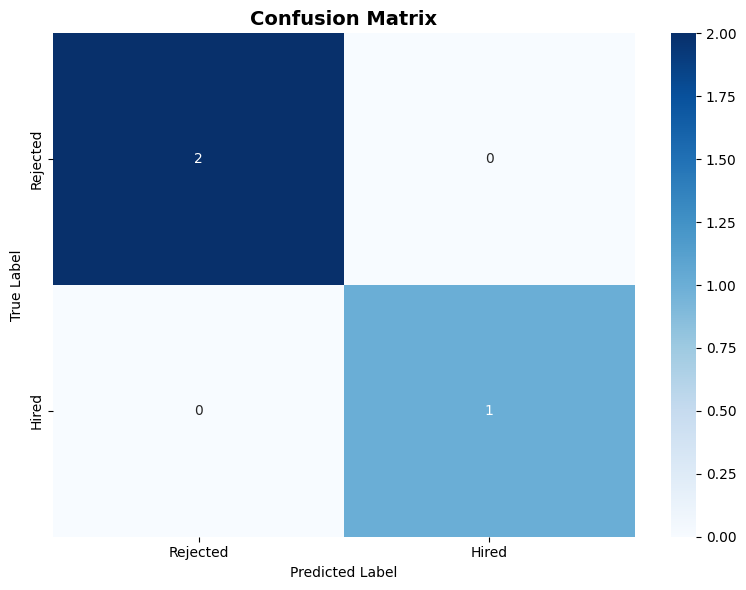


✅ Confusion matrix plotted


In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Hired'],
            yticklabels=['Rejected', 'Hired'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n✅ Confusion matrix plotted")

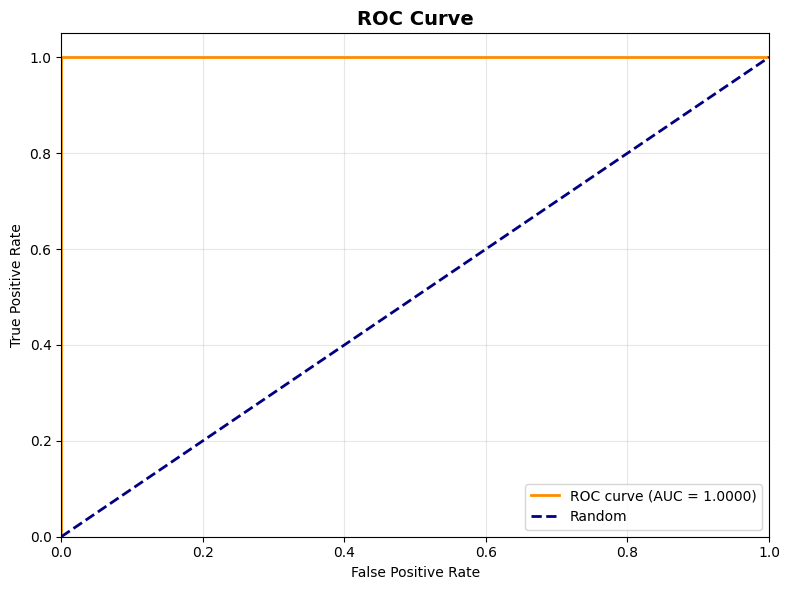

✅ ROC curve plotted


In [14]:
# ROC Curve (if enough samples)
try:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✅ ROC curve plotted")
except:
    print("⚠️ ROC curve not available (need more test samples)")

## 7. Feature Importance Analysis

In [15]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Feature Importance Rankings:")
print(feature_importance.to_string(index=False))


📊 Feature Importance Rankings:
              feature  importance
overall_quality_score         1.0
       avg_word_count         0.0
     avg_completeness         0.0
     avg_tech_density         0.0
  avg_structure_score         0.0
avg_specificity_score         0.0
        avg_sentiment         0.0
  total_tech_keywords         0.0
   total_action_verbs         0.0
    pct_with_examples         0.0
     pct_with_metrics         0.0
     pct_with_actions         0.0
    consistency_score         0.0


C:\Users\rayan\AppData\Local\Temp\ipykernel_153556\1017309380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


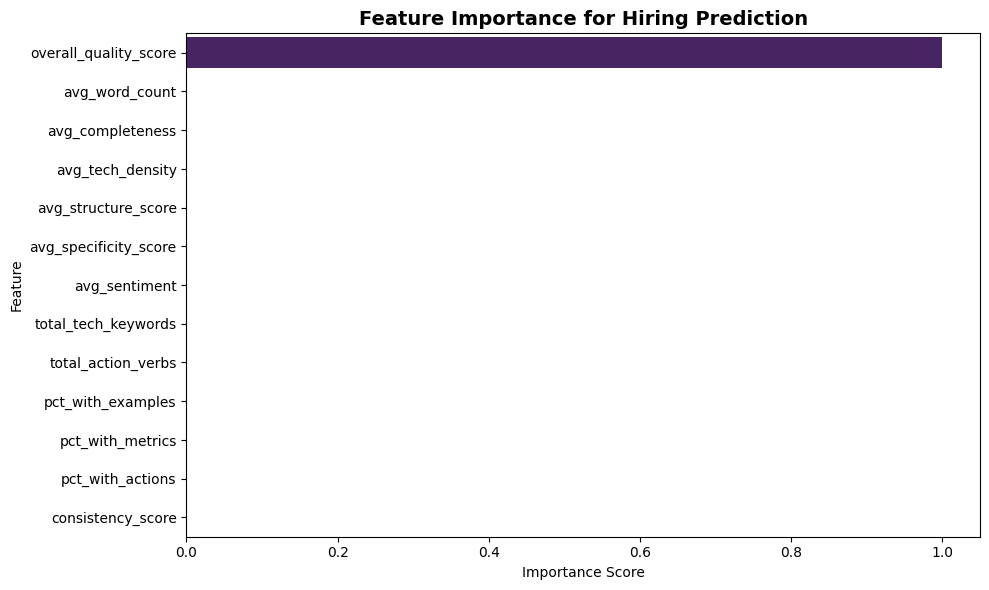

✅ Feature importance plotted


In [16]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Hiring Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("✅ Feature importance plotted")

## 8. Save Model to Disk

In [17]:
# Create models directory
model_dir = '../models/hiring_predictor'
os.makedirs(model_dir, exist_ok=True)

# Save model
model_path = os.path.join(model_dir, 'xgboost_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ Model saved to {model_path}")

# Save scaler
scaler_path = os.path.join(model_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved to {scaler_path}")

# Save feature names
features_path = os.path.join(model_dir, 'feature_names.pkl')
with open(features_path, 'wb') as f:
    pickle.dump(feature_columns, f)
print(f"✅ Feature names saved to {features_path}")

print("\n🎉 All model artifacts saved successfully!")

✅ Model saved to ../models/hiring_predictor\xgboost_model.pkl
✅ Scaler saved to ../models/hiring_predictor\scaler.pkl
✅ Feature names saved to ../models/hiring_predictor\feature_names.pkl

🎉 All model artifacts saved successfully!


## 9. Test Predictions

In [18]:
# Test prediction on a sample
sample_idx = 0
sample_features = X_test_scaled[sample_idx:sample_idx+1]
sample_pred_proba = model.predict_proba(sample_features)[0]

print(f"\n🧪 Test Prediction:")
print(f"Response ID: {response_ids[sample_idx]}")
print(f"True label: {'Hired' if y_test.iloc[sample_idx] == 1 else 'Rejected'}")
print(f"Predicted probability of hire: {sample_pred_proba[1]:.2%}")
print(f"Predicted label: {'Hired' if sample_pred_proba[1] >= 0.5 else 'Rejected'}")

# Show top features for this prediction
print(f"\nTop 5 features:")
feature_values = X_test.iloc[sample_idx]
for feat, imp in feature_importance.head(5).values:
    print(f"  - {feat}: {feature_values[feat]:.2f} (importance: {imp:.3f})")


🧪 Test Prediction:
Response ID: train_hired_1
True label: Rejected
Predicted probability of hire: 47.50%
Predicted label: Rejected

Top 5 features:
  - overall_quality_score: 37.00 (importance: 1.000)
  - avg_word_count: 50.00 (importance: 0.000)
  - avg_completeness: 45.00 (importance: 0.000)
  - avg_tech_density: 2.50 (importance: 0.000)
  - avg_structure_score: 35.00 (importance: 0.000)


## 10. Summary

✅ Model training complete!

The XGBoost hiring predictor has been trained and saved. You can now:

1. Use the `/api/questionnaire/predict/{response_id}` endpoint to get predictions
2. View predictions in the HR Portal frontend
3. Retrain the model as more labeled data becomes available

**Next steps:**
- Restart the backend to load the new model
- Test predictions via the API
- Collect more training data through HR feedback